## Problem formulation

We imagine a regression problem in $D$ dimensions with inputs $\mathbf{x}_i \in \mathbb{R}^{D}$ and one-dimensional outputs $y_i \in \mathbb{R}$ on the form of

$$ y_i = f(\mathbf{x}_i) + \epsilon(\mathbf{x}_i) $$

where $\epsilon(\mathbf{x}_i) = \mathcal{N}(0,\sigma^2(\mathbf{x}_i))$ is a noise term. If the variance $\sigma^2(\mathbf{x}_i)$ is constant it is called *homoscedastic* and if not *heteroscedastic*. 



Our goal is to learn a probabilistic regression model $p_{\theta}(y|\mathbf{x})$, which for now we will assume is a normal distribution:

$$p_{\theta}(y|\mathbf{x}) = \mathcal{N}(y|\mu(\mathbf{x}),\sigma_p^2(\mathbf{x}))$$

which is the case for Gaussian Processes (GPs) with predictive variance $\sigma_p^2(\mathbf{x})$. We want the model not only to have a good prediction error (e.g. a low mean squared error) but also has well-calibrated uncertainties $\sigma_p^2(\mathbf{x})$. We shall assume, the predictive variance has a (either analytical or approximal)  decomposition:

$$\sigma_p^2(\mathbf{x}) = \sigma_e^2(\mathbf{x}) + \sigma_a^2(\mathbf{x})$$

where $\sigma_a^2(\mathbf{x})$ is the *aleatoric* noise (irreducible inherent randomness in the data-generating process) and $\sigma_e^2(\mathbf{x})$ is the *epidemestic* noise (lack of knowledge, i.e. it can be reduced when new information / data is presented). Although the predictive variance from the GP has this exact explicit decomposition: 
$$\sigma_p^2(\mathbf{x})=\underbrace{K(\mathbf{x}_*,\mathbf{x}_*)-K(\mathbf{x}_*,\mathbf{X})(K(\mathbf{X},\mathbf{X})+\sigma_nI)^{-1}K(\mathbf{X},\mathbf{x}_*)}_{\sigma^2_e} + \underbrace{\sigma_n^2I}_{\sigma^2_a}$$

there is no obvious decomposition in most other models. However, in this paper we argue that if a regressor has a bias-variance decomposition, we can approximate both terms in the above equation. 

### Bias-variance decomposition

\begin{split}
\mathbb{E}[(y-\hat{y})^2] &= E[(f+\epsilon-\hat{y})^2] \\
&= E[(f-\hat{y})^2+2(f-\hat{y})\epsilon+\epsilon^2]\\
&= E[(f-\hat{y})^2]+2E[(f-\hat{y})\epsilon]+E[\epsilon^2]\\
&= E\left[\left(f - E(\hat{y}) + E(\hat{y})-\hat{y} \right)^2 \right] + 2E[(f-\hat{y})\epsilon]+\sigma_a^2 \\
& = Var(\hat{y}) + \text{Bias}^2(\hat{y}) + \sigma_a^2.
\end{split}


|                   | $\sigma_p$ | $\sigma_e$ 
| ---               | ---           | --- 
| $\mathcal{C}_y$   |   Kuleshov | X
| $\mathcal{C}_f$   | Our | Our


### $\mathcal{C}_y$ vs. $\mathcal{C}_f$

In a real-world application scenario, we could imagine having access to one or more of the following properties of the system of interest:

- Have access to or being able to repeat the experiment for the same input $\mathbf{x}_i$
- Have knowledge of the true underlying function $f(\mathbf{x}_i)$ for certain ranges of $\mathbf{x}_i$
- Have knowledge of $\sigma^2(\mathbf{x}_i)$ for certain ranges of $\mathbf{x}_i$
- Have an estimate of $|y_i - f(\mathbf{x}_i)|$ for certain ranges of $\mathbf{x}_i$

The first the scenario in areas such as bayesian optimization, active learning and reinforcement learning. The second and third points might not be realistic all real-world problems, but given the first principle, we could estimate both $f(\mathbf{x}_i)$ and $\sigma^2(\mathbf{x}_i)$ by averaging over experiments with same input. Furthermore, if the noise is homoscedastic, on such repeatable experiment will result in knowing $\sigma^2(\mathbf{x}_i) \,\, \forall \,\, i$. Lastly, we encounter many apparatuses in areas such as physics and chemistry.


In [22]:
from imports.ml import *
from imports.general import *
from src.calibration import Calibration
from src.parameters import Parameters

In [23]:
def make_dataset(seed:int=0,n_train:int=10,sigma_data:float = 1e-1):
    np.random.seed(seed)
    n = 1000
    x = np.linspace(0,1,n)
    f = np.sin(2*x)
    y = f + np.random.normal(0,sigma_data,size=f.shape)
    return x,f,y,train_test_split(x, y, shuffle=True, train_size=n_train/n, random_state=42)


In [24]:
def fit_gp(seed:int=0,sigma_initial:float = None):
    np.random.seed(seed)
    rbf_kernel = 1.0 * RBF(length_scale_bounds=(1e-5, 1e3))
    if sigma_initial is not None:
        noise_kernel = WhiteKernel(noise_level=sigma_data**2,noise_level_bounds="fixed") 
    else:
        noise_kernel = WhiteKernel(noise_level_bounds=(1e-10, 1e1)) 
    kernel = rbf_kernel + noise_kernel
    model = GaussianProcessRegressor(kernel=kernel).fit(x_train[:,np.newaxis],y_train)
    y_pred,sigma_p = model.predict(x[:,np.newaxis],return_std=True)
    if sigma_initial is not None:
        sigma_a = np.full(sigma_p.shape,sigma_initial)
    else:
        sigma_a = np.full(sigma_p.shape,np.sqrt(np.exp(model.kernel_.theta[-1])))
    sigma_e = np.sqrt(sigma_p**2-sigma_a**2)
    bias = np.mean((f-y_pred)**2)
    # print(model.kernel_)
    # print(model.kernel_.theta)
    # print(np.exp(model.kernel_.theta[-1]))
    # print(np.mean(sigma_a))
    # print(np.mean(sigma_p))
    return sigma_p,sigma_a,sigma_e,bias,y_pred



In [25]:
def plot_predictive(save:bool=False):
    if np.mean(sigma_a) > np.mean(sigma_e):
        alpha_a,alpha_e = 0.1,0.2
    else:
        alpha_e,alpha_a = 0.1,0.2

    fig = plt.figure(figsize=(10,5))
    plt.plot(x,f,color="black",label="f")
    plt.plot(x_train,y_train,".",color="black",label="train",alpha=0.6)
    plt.plot(x_test,y_test,".",color="green",label="test",alpha=0.1)
    plt.plot(x,y_pred,color="blue",label="GP")
    plt.fill_between(
        x,
        f,
        y_pred,
        color="red",
        alpha=0.5,
        label="Bias",
    )
    # plt.fill_between(
    #     x,
    #     y_pred - sigma_a,
    #     y_pred + sigma_a,
    #     facecolor="none",
    #     alpha=alpha_a,
    #     hatch="X", 
    #     linewidth=0.0,
    #     edgecolor="blue", 
    # )
    plt.plot(
        x,
        y_pred - sigma_a,
        "--",
        color="blue",
        label=r"$\sigma_a$" + " (noise)",
    )
    plt.plot(
        x,
        y_pred + sigma_a,
        "--",
        color="blue",
    )
    plt.fill_between(
        x,
        y_pred - sigma_e,
        y_pred + sigma_e,
        color="blue",
        alpha=alpha_e,
        label=r"$\sigma_e$" + " (variance)",
    )
    plt.fill_between(
        x,
        y_pred - sigma_p,
        y_pred + sigma_p,
        color="blue",
        alpha=0.05,
        label=r"$\sigma_p$",
    )
    
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.ylim([0.0,1.2])
    # plt.xlim([0.2,1.0])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    if save:
        fig.savefig(f"visualizations/figures/predictive-example.pdf")
    plt.show()

def plot_calibration(summary:Dict,save:bool=False):
    fig = plt.figure(figsize=(10,5))
    plt.plot(summary["y_p_array"],summary["y_p_array"],"--")
    plt.plot(summary["y_p_array"],summary["y_calibration"],"--o",label=r"$\mathcal{C}_y$ "+f"(error={summary['y_calibration_mse']:.2E})",color="blue")
    plt.plot(summary["f_p_array"],summary["f_calibration"],"--o",label=r"$\mathcal{C}_f$ "+f"(error={summary['f_calibration_mse']:.2E})",color="black")
    plt.xlabel("Expected Confidence Level")
    plt.ylabel("Observed Confidence Level")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    if save:
        fig.savefig(f"visualizations/figures/calibration-example.pdf")
    plt.show()

In [26]:
sigma_data=1e-1
x,f,y,(x_train, x_test, y_train, y_test) = make_dataset(seed=1,n_train=10,sigma_data=sigma_data)
sigma_p,sigma_a,sigma_e,bias,y_pred = fit_gp(seed=0,sigma_initial=sigma_data)
# print("Model bias",bias)
# print("Model std",np.mean(sigma_e))
# print("Predictive std",np.mean(sigma_p))
# print("Estimated noise std",np.mean(sigma_a))
# print("True noise std",sigma_data)
parameters = Parameters()
calibration = Calibration(parameters)

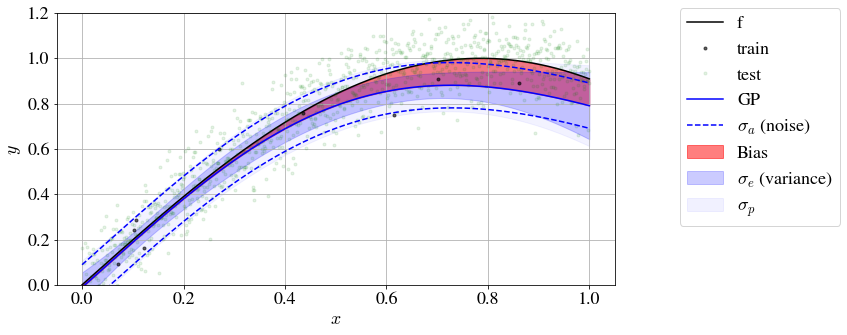

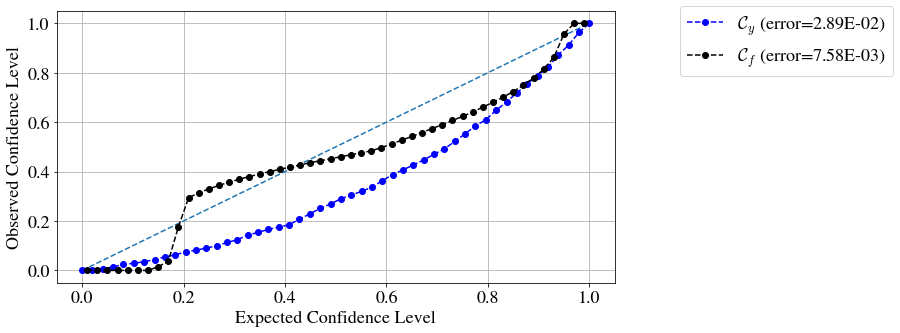

In [27]:
calibration.calibration_global(y_pred,sigma_p,y)
calibration.check_f_calibration(y_pred,sigma_e,f)
plot_predictive(save=True)
plot_calibration(calibration.summary,save=True)

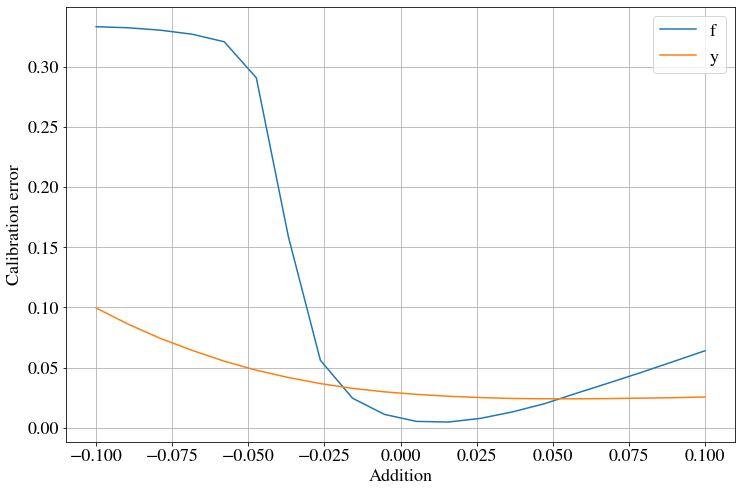

In [28]:
y_mses = []
f_mses = []
add_array = np.linspace(-0.1,0.1,20)
for adding in add_array:
    sigma_e_ = sigma_e + adding
    calibration.check_f_calibration(y_pred,sigma_e_,f)
    f_mses.append(calibration.summary["f_calibration_mse"])

    sigma_p_ = sigma_p + adding
    calibration.calibration_global(y_pred,sigma_p_,y)
    y_mses.append(calibration.summary["y_calibration_mse"])

plt.plot(add_array,f_mses,label="f")
plt.plot(add_array,y_mses,label="y")
plt.xlabel("Addition")
plt.ylabel("Calibration error")
plt.legend()

In [29]:
sigma_e = sigma_e + add_array[np.argmin(f_mses)]
sigma_p = sigma_p + add_array[np.argmin(y_mses)]

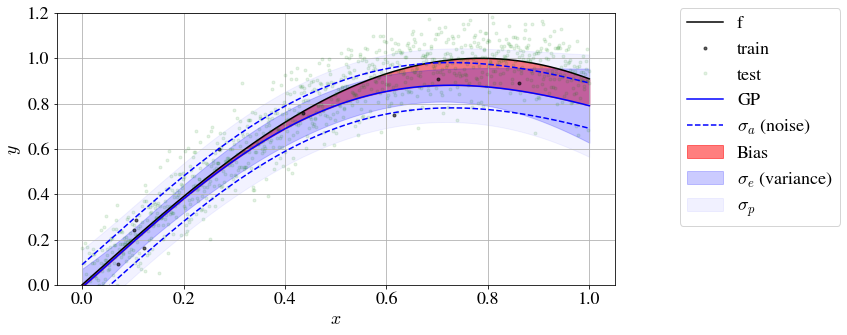

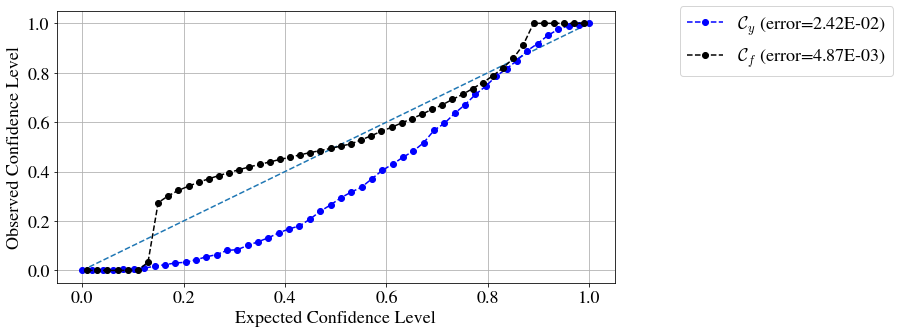

In [30]:
calibration.calibration_global(y_pred,sigma_p,y)
calibration.check_f_calibration(y_pred,sigma_e,f)
plot_predictive(save=True)
plot_calibration(calibration.summary,save=True)